In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
states = pd.read_csv("/content/drive/MyDrive/NRDC Discovery Group/ipums_2019.csv")
states.head(); # 547275 rows × 52 columns

### **Washington State**

In [5]:
washington = states[states['STATEICP'] == 73]
washington.head() # 77879 rows × 52 columns

,YEAR,SAMPLE,SERIAL,CBSERIAL,NUMPREC,HHWT,HHTYPE,CBHHTYPE,CLUSTER,REGION,STATEICP,STATEFIP,COUNTYICP,COUNTYFIP,DENSITY,METRO,METPOP10,PCTMETRO,CITY,STRATA,GQ,OWNERSHP,OWNERSHPD,MORTGAGE,RENT,RENTGRS,COSTELEC,COSTGAS,COSTWATR,COSTFUEL,HHINCOME,FOODSTMP,VACANCY,HOTWATER,FUELHEAT,NFAMS,PERNUM,PERWT,FAMUNIT,FAMSIZE,NCHILD,SEX,AGE,RACE,RACED,HISPAN,HISPAND,TRIBE,TRIBED,EDUC,EDUCD,INCTOT
469396,2019,201901,1355967,2019010000019,1,55.0,0,0,2019013559671,42,73,53,0,0,1758.5,4,253340,100.0,0,1070253,3,0,0,0,0,0,0,0,0,0,9999999,1,0,0,0,1,1,55.0,1,1,0,1,28,1,100,1,100,0,0,3,30,0
469397,2019,201901,1355968,2019010000084,1,71.0,0,0,2019013559681,42,73,53,330,33,2425.1,4,3439809,100.0,0,1161453,3,0,0,0,0,0,0,0,0,0,9999999,1,0,0,0,1,1,71.0,1,1,0,1,76,1,100,0,0,0,0,11,114,26100
469398,2019,201901,1355969,2019010000106,1,20.0,0,0,2019013559691,42,73,53,330,33,5962.1,2,3439809,100.0,6430,1160553,4,0,0,0,0,0,0,0,0,0,9999999,2,0,0,0,1,1,20.0,1,1,0,1,50,1,100,0,0,0,0,4,40,5000
469399,2019,201901,1355970,2019010000152,1,9.0,0,0,2019013559701,42,73,53,0,0,237.8,1,55220,0.0,0,1190053,3,0,0,0,0,0,0,0,0,0,9999999,2,0,0,0,1,1,9.0,1,1,0,2,20,1,100,0,0,0,0,4,40,24000
469400,2019,201901,1355971,2019010000181,1,142.0,0,0,2019013559711,42,73,53,330,33,8784.4,2,3439809,100.0,6430,1160253,4,0,0,0,0,0,0,0,0,0,9999999,1,0,0,0,1,1,142.0,1,1,0,2,18,1,100,0,0,0,0,6,63,2400


In [ ]:
washington.isna().sum();

In [ ]:
# this will show how many counties the state, from the entire dataset, is representing (line after puts it into a dataframe)
washington['COUNTYICP'].unique()

# new dataframe for unique ICPs
uniqueicps = pd.DataFrame(data = washington['COUNTYICP'].unique(), index=None, columns=["COUNTYICP"])

# manually searched county names (put into list and add as column)
uniqueicps['County Names'] = ["N/A", "King", "Spokane", "Pierce", "Clark", "Snohomish", "Kitsap", "Yakima", "Thurston", "Whatcom"]

# merging washington dataframe with uniqueicps dataframe
matched_counties = pd.merge(
	washington,
	uniqueicps,
	on="COUNTYICP")

# this ensures these columns will be next to each other 
matched_counties['COUNTYICP'], matched_counties['County Names'] = matched_counties.pop('COUNTYICP'), matched_counties.pop('County Names') 

# for climate zones (I just looked up a map and matched counties accordingly)
climate_zones = pd.DataFrame(data = matched_counties['County Names'].unique(), index=None, columns=["County Names"])
climate_zones['Climate Zones'] = ["N/A", "Northwest", "Eastern", "Olympic", "Southwest", 
                                  "Northwest", "Olympic", "South Central", "Olympic", "Northwest"]

# creating new set 
filtered_washington = pd.merge(matched_counties, climate_zones, on = 'County Names')

# this ensures these columns will be next to each other 
filtered_washington['County Names'], filtered_washington['Climate Zones'] = filtered_washington.pop('County Names'), filtered_washington.pop('Climate Zones')

# move columns below to the front of dataframe
cols_to_move = ['COUNTYICP', 'County Names', 'Climate Zones']
filtered_washington = filtered_washington[cols_to_move + [col for col in filtered_washington.columns if col not in cols_to_move]] 

# to determine if "OWNERSHP" column = rented, owned, or N/A (.replace function)
filtered_washington["OWNERSHP"] = filtered_washington["OWNERSHP"].replace({1: 'Owned', 2: 'Rented', 0: 'N/A'})

# reassess METRO values

filtered_washington["METRO"] = filtered_washington["METRO"].replace({3:2, 4:2}).astype(object)
  # 0 = not determinable
  # 1 = not in METRO area
  # 2 = in METRO area

In [ ]:
# renaming columns 
filtered_washington.rename(columns={"COUNTYICP":"County ICPs", "OWNERSHP":"Tenure", 
                                    "COSTELEC":"Annual Electricity Costs", "COSTGAS":"Annual Gas Costs", 
                                    "COSTFUEL":"Annual Fuel Costs", "COSTWATR":"Annual Water Costs"}, inplace = True)

# removing outliers 
filtered_washington = filtered_washington[filtered_washington['HHINCOME'] < 999999]
filtered_washington = filtered_washington[filtered_washington['HHINCOME'] >= 0]
filtered_washington = filtered_washington[filtered_washington['Annual Fuel Costs'] < 9999]
filtered_washington = filtered_washington[filtered_washington['Annual Gas Costs'] < 9999]
filtered_washington = filtered_washington[filtered_washington['Annual Electricity Costs'] < 9999]
filtered_washington = filtered_washington[filtered_washington['Annual Water Costs'] < 9999]
filtered_washington.head() # 74462 rows × 54 columns

,County ICPs,County Names,Climate Zones,YEAR,SAMPLE,SERIAL,CBSERIAL,NUMPREC,HHWT,HHTYPE,CBHHTYPE,CLUSTER,REGION,STATEICP,STATEFIP,COUNTYFIP,DENSITY,METRO,METPOP10,PCTMETRO,CITY,STRATA,GQ,Tenure,OWNERSHPD,MORTGAGE,RENT,RENTGRS,Annual Electricity Costs,Annual Gas Costs,Annual Water Costs,Annual Fuel Costs,HHINCOME,FOODSTMP,VACANCY,HOTWATER,FUELHEAT,NFAMS,PERNUM,PERWT,FAMUNIT,FAMSIZE,NCHILD,SEX,AGE,RACE,RACED,HISPAN,HISPAND,TRIBE,TRIBED,EDUC,EDUCD,INCTOT
877,0,N/A,N/A,2019,201901,1359289,2019000000012,2,71.0,1,2,2019013592891,42,73,53,0,362.4,0,71271,80.44,0,1120053,1,Owned,12,1,0,0,960,9993,900,9993,56600,1,0,4,7,1,1,71.0,1,2,0,1,79,1,100,0,0,0,0,7,71,43600
878,0,N/A,N/A,2019,201901,1359289,2019000000012,2,71.0,1,2,2019013592891,42,73,53,0,362.4,0,71271,80.44,0,1120053,1,Owned,12,1,0,0,960,9993,900,9993,56600,1,0,4,7,1,2,76.0,1,2,0,2,68,1,100,0,0,0,0,6,64,13000
879,0,N/A,N/A,2019,201901,1359291,2019000000158,1,66.0,4,9,2019013592911,42,73,53,0,448.2,0,86810,55.36,0,1020053,1,Owned,13,3,0,0,1080,9993,300,200,70000,1,0,4,4,1,1,67.0,1,1,0,1,64,1,100,0,0,0,0,8,81,70000
880,0,N/A,N/A,2019,201901,1359298,2019000000623,2,66.0,1,2,2019013592981,42,73,53,0,280.3,2,110884,100.00,0,1030053,1,Owned,13,3,0,0,480,9993,1100,9993,197000,1,0,4,4,1,1,67.0,1,2,0,1,69,1,100,0,0,0,0,6,63,160000
881,0,N/A,N/A,2019,201901,1359298,2019000000623,2,66.0,1,2,2019013592981,42,73,53,0,280.3,2,110884,100.00,0,1030053,1,Owned,13,3,0,0,480,9993,1100,9993,197000,1,0,4,4,1,2,73.0,1,2,0,2,69,1,100,0,0,0,0,6,63,37000


In [ ]:
# representative of state (Washington state population = ~7 mill)
sum(filtered_washington['PERWT'])

7459276.0

In [ ]:
filtered_washington['SERIAL'].value_counts()

1383058    20
1361396    20
1372436    16
1378742    13
1360481    13
           ..
1387914     1
1387113     1
1389162     1
1376876     1
1361779     1
Name: SERIAL, Length: 30183, dtype: int64

# **Tenure**

In [ ]:
# 0.729391 = Owned
# 0.270608 = Rented
na_tenure = filtered_washington['SERIAL'].drop_duplicates()
na_tenure = filtered_washington['Tenure'].value_counts()
na_tenure

Owned     54231
Rented    20231
Name: Tenure, dtype: int64

In [ ]:
filtered_washington.shape

(74462, 54)

In [ ]:
(20231/74462)*100

27.169562998576456

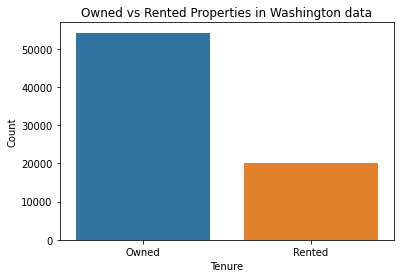

In [ ]:
tenure = filtered_washington.groupby('Tenure', as_index = False).size()
sns.barplot(x = 'Tenure', y = 'size', data = tenure)
plt.title('Owned vs Rented Properties in Washington data')
plt.ylabel('Count');

# **County Percentages**

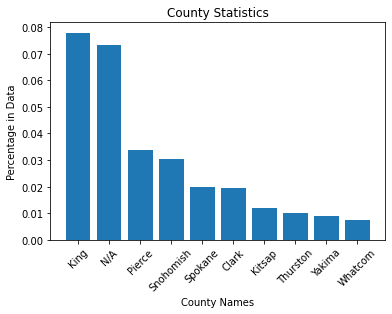

In [ ]:
# Unidentified (N/A) = 0.249630
# Labeled = 0.750369
washington_county_prop = pd.DataFrame(filtered_washington['County ICPs'].value_counts()/sum(filtered_washington['County ICPs']))*100
washington_county_prop = washington_county_prop.reset_index()
washington_county_prop = washington_county_prop.rename(columns = {"index": "County ICP", "County ICPs":"Percentage"})
washington_county_prop['Names'] = ["King", "N/A", "Pierce","Snohomish", "Spokane", 
                                  "Clark", "Kitsap", "Thurston", "Yakima", "Whatcom"]
# county percentages
plt.bar(washington_county_prop['Names'], washington_county_prop['Percentage'])
plt.title('County Statistics')
plt.xlabel('County Names')
plt.ylabel('Percentage in Data')
plt.xticks(rotation = 45)
plt.show()

In [ ]:
(filtered_washington['County Names'].value_counts() / filtered_washington.shape[0]) * 100

King         26.589401
N/A          24.963068
Pierce       11.474309
Kitsap       10.393221
Spokane       6.733636
Clark         6.708120
Snohomish     4.139024
Thurston      3.405764
Yakima        3.080766
Whatcom       2.512691
Name: County Names, dtype: float64

# **Metro Counts**

In [ ]:
metro = pd.DataFrame(filtered_washington.groupby(['County Names','METRO']).size())
metro = metro.reset_index()
metro = metro.rename(columns = {0:'Total'})
metro = metro.pivot_table(values = 'Total', columns = 'METRO',index = 'County Names').fillna(0).astype(int)
metro = metro.rename(columns = {0: 'Undeterminable', 1: 'Rural', 2: 'Metropolitan'})
metro

METRO,Undeterminable,Rural,Metropolitan
County Names,,,
Clark,0,0,4995
King,0,0,19799
Kitsap,0,0,7739
N/A,10475,3926,4187
Pierce,0,0,8544
Snohomish,0,0,3082
Spokane,0,0,5014
Thurston,0,0,2536
Whatcom,0,0,1871


In [ ]:
# percent of Metro categories in data
print((sum(metro['Undeterminable'])/74481)*100, (sum(metro['Rural'])/74481)*100, (sum(metro['Metropolitan'])/74481)*100)
print('Undeterminable','Rural','Metropolitan')

14.063989473825538 5.271142976061008 80.63935768853801
Undeterminable Rural Metropolitan


Text(0, 0.5, 'Total')

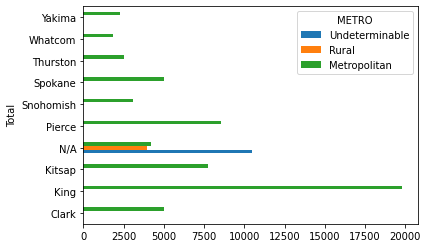

In [ ]:
metrobar = metro.plot(kind = 'barh')
metrobar.set_ylabel('Total')

In [ ]:
# Total 

metro_props = pd.DataFrame(((metro['Undeterminable'] / 74481)*100,
               (metro['Rural'] / 74481)*100, 
               (metro['Metropolitan'] / 74481)*100))
metro_props

County Names,Clark,King,Kitsap,N/A,Pierce,Snohomish,Spokane,Thurston,Whatcom,Yakima
Undeterminable,0.000000,0.000000,0.000000,14.063989,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
Rural,0.000000,0.000000,0.000000,5.271143,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000
Metropolitan,6.706408,26.582618,10.390569,5.621568,11.471382,4.137968,6.731918,3.404895,2.51205,3.07998


# **Household Data**#

Washington Family Size Median Income: https://www.dshs.wa.gov/esa/eligibility-z-manual-ea-z/state-median-income-chart

Income status breakdown: https://www.energy.gov/eere/slsc/low-income-community-energy-solutions#:~:text=Energy%20burden%20is%20defined%20as,income%20spent%20on%20energy%20costs 

In [ ]:
household_data = filtered_washington[['METRO','SERIAL',  'RENTGRS','FAMSIZE', 'County Names', 'Climate Zones', 'Tenure', 
                                      'Annual Electricity Costs', 'Annual Gas Costs', 'Annual Water Costs',
                                      'Annual Fuel Costs', 'HHINCOME', 'HHWT', 'NFAMS']]

In [ ]:
# consider applying same function for AMIs County Level Analysis
def class_evaluator(df):
  classes = []
  for i in df['Income Proportion for Classes']:
      if i > 0 and i < 0.3:
          classes.append('Extremely Low Income')
      elif i >= 0.3 and i < 0.5:
          classes.append('Very Low Income')
      elif i >= 0.5 and i < 0.8:
          classes.append('Low Income')
      elif i >= 0.8:
          classes.append('Not Low Income')
      else:
          classes.append('Above Median Income')
  return classes

In [ ]:
income_bounds = np.array([0,48204, 63036, 77856, 92688, 107520, 122353, 125136, 127920, 130704, 133488, 136272, 139056, 141840])
income_bounds = np.append(income_bounds, np.arange(0 + 141840, 300000, 2500))
household_data.loc[:,'Family Size Median Incomes'] = [income_bounds[i] for i in household_data['FAMSIZE']]
household_data.loc[:,'Meets Income Threshold'] = household_data['HHINCOME'] >= household_data['Family Size Median Incomes']

household_data.loc[:,'Total Energy Costs'] = (household_data['Annual Electricity Costs'] + household_data['Annual Fuel Costs'] + household_data['Annual Gas Costs'] + household_data['Annual Water Costs'])
household_data.loc[:,'[WEIGHTED] Energy Spend'] = (household_data['HHWT'] * household_data['Total Energy Costs'])
household_data.loc[:,'[WEIGHTED] Household Occupancy'] = (household_data['FAMSIZE'] * household_data['HHWT'])
household_data.loc[:,'[WEIGHTED] Gas Spend'] = (household_data['Annual Gas Costs'] * household_data['HHWT'])
household_data.loc[:,'[WEIGHTED] Household Occupancy'] = (household_data['FAMSIZE'] * household_data['HHWT'])
household_data.loc[:,'Income Proportion for Classes'] = (household_data['HHINCOME'] / household_data['Family Size Median Incomes'])


# thanks, Sean 
poverty_bounds = np.array([0, 12490, 16910, 21330, 25750, 31170, 34590, 39010, 43430])
poverty_bounds = np.append(poverty_bounds, np.arange(4540 + 44660, 1000000, 43430))
household_data.loc[:,'Poverty Line'] = [poverty_bounds[size] for size in household_data['FAMSIZE']]
household_data.loc[:,'Poverty'] = household_data['HHINCOME'] <= household_data['Poverty Line']

household_data.loc[:,'Classes'] = class_evaluator(household_data)
household_data.drop(columns = ['Family Size Median Incomes','Income Proportion for Classes', 'Poverty Line'], inplace = True)
household_data.head()


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,METRO,SERIAL,RENTGRS,FAMSIZE,County Names,Climate Zones,Tenure,Annual Electricity Costs,Annual Gas Costs,Annual Water Costs,Annual Fuel Costs,HHINCOME,HHWT,NFAMS,Meets Income Threshold,Total Energy Costs,[WEIGHTED] Energy Spend,[WEIGHTED] Household Occupancy,[WEIGHTED] Gas Spend,Poverty,Classes
877,0,1359289,0,2,N/A,N/A,Owned,960,9993,900,9993,56600,71.0,1,False,21846,1551066.0,142.0,709503.0,False,Not Low Income
878,0,1359289,0,2,N/A,N/A,Owned,960,9993,900,9993,56600,71.0,1,False,21846,1551066.0,142.0,709503.0,False,Not Low Income
879,0,1359291,0,1,N/A,N/A,Owned,1080,9993,300,200,70000,66.0,1,True,11573,763818.0,66.0,659538.0,False,Not Low Income
880,2,1359298,0,2,N/A,N/A,Owned,480,9993,1100,9993,197000,66.0,1,True,21566,1423356.0,132.0,659538.0,False,Not Low Income
881,2,1359298,0,2,N/A,N/A,Owned,480,9993,1100,9993,197000,66.0,1,True,21566,1423356.0,132.0,659538.0,False,Not Low Income


In [ ]:
household_data.shape

(74462, 21)

In [ ]:
familysize = household_data[['NFAMS']]
familysize.value_counts()

NFAMS
1        67894
2         4584
3         1179
4          433
5          196
6           51
15          36
8           32
10          21
19          20
9            9
7            7
dtype: int64

In [ ]:
status_breakdown = household_data[['Tenure', 'Classes']]

In [ ]:
status_breakdown.groupby('Classes',  as_index = False).size()

,Classes,size
0,Above Median Income,355
1,Extremely Low Income,4549
2,Low Income,10957
3,Not Low Income,52742
4,Very Low Income,5859


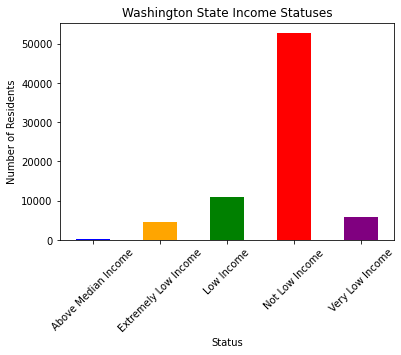

In [ ]:
cl2 = status_breakdown.groupby(['Classes']).size()
my_colors = 'rgbky'
cl2.plot(kind = 'bar', color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Washington State Income Statuses')
plt.xlabel('Status')
plt.xticks(rotation = 45)
plt.ylabel('Number of Residents');

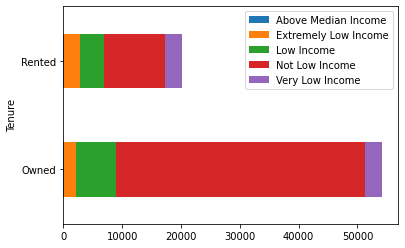

In [ ]:
tenureandlevels = status_breakdown.groupby(['Tenure','Classes']).size().unstack()
tenureandlevels = tenureandlevels.plot(kind='barh',stacked=True,legend=True)
tenureandlevels.legend();

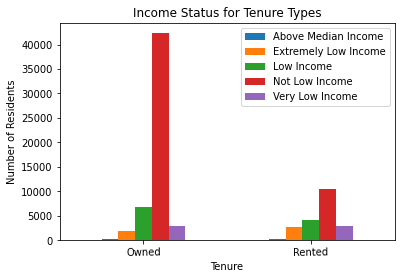

In [ ]:
buildingstypes = household_data.groupby(['Tenure','Classes']).size().unstack()
buildingstypes = buildingstypes.plot(kind='bar',stacked=False,legend=True)
plt.title('Income Status for Tenure Types')
plt.ylabel('Number of Residents')
plt.xticks(rotation = 1)
buildingstypes.legend();

In [ ]:
wash_income_households = household_data.pivot_table(index = ['FAMSIZE', 'Meets Income Threshold'], aggfunc = 'count')[['SERIAL']].rename(columns = {'SERIAL' : 'Total'})
wash_income_households.head();

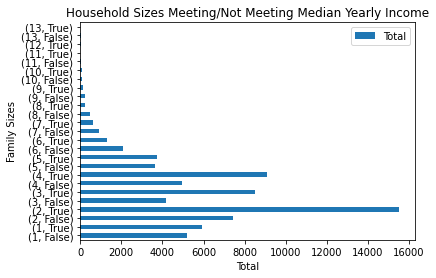

In [ ]:
wash_income_households.plot(kind = 'barh')
plt.title('Household Sizes Meeting/Not Meeting Median Yearly Income')
plt.xlabel('Total')
plt.ylabel('Family Sizes');

In [ ]:
wash_poverty_households = household_data.pivot_table(index = ['FAMSIZE', 'Poverty'], aggfunc = 'count')[['SERIAL']].rename(columns = {'SERIAL' : 'Count'})
wash_poverty_households.head();

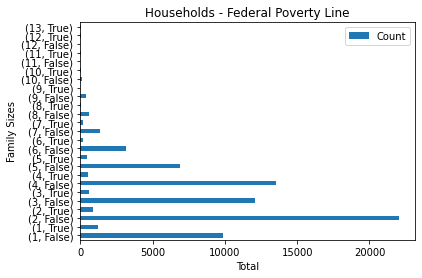

In [ ]:
wash_poverty_households.plot(kind = 'barh')
plt.title('Households - Federal Poverty Line')
plt.xlabel('Total')
plt.ylabel('Family Sizes');

In [ ]:
rentownpoverty = household_data[['Tenure', 'Poverty']]
rentownpoverty[(rentownpoverty['Tenure'] =='Owned') & (rentownpoverty['Poverty'] == True)] # 1717 / 74107
rentownpoverty[(rentownpoverty['Tenure'] =='Owned') & (rentownpoverty['Poverty'] == False)] # 52336 / 74107
rentownpoverty[(rentownpoverty['Tenure'] =='Rented') & (rentownpoverty['Poverty'] == True)] # 2371 / 74107
rentownpoverty[(rentownpoverty['Tenure'] =='Rented') & (rentownpoverty['Poverty'] == False)] # 17683 / 74107
rentownpoverty

,Tenure,Poverty
877,Owned,False
878,Owned,False
879,Owned,False
880,Owned,False
881,Owned,False
...,...,...
77874,Owned,False
77875,Owned,False
77876,Owned,False
77877,Owned,False


# **Individual Data**

# New Section

In [ ]:
# (74462, 21)
individual_data = filtered_washington[['YEAR','FAMSIZE','METRO','SERIAL','HHWT','HHTYPE','County ICPs','AGE','County Names','Climate Zones','STRATA', 'GQ','Tenure',	
                                   'OWNERSHPD','RENTGRS','Annual Electricity Costs', 'Annual Gas Costs',
                                   'Annual Water Costs', 'Annual Fuel Costs','HHINCOME','PERNUM','PERWT', 'NFAMS']]

In [ ]:
individual_data['Sum Energy Costs'] = (individual_data['Annual Electricity Costs'] + individual_data['Annual Fuel Costs'] + individual_data['Annual Gas Costs'] + individual_data['Annual Water Costs'])
individual_data['Energy Cost Burden'] = (individual_data['HHINCOME'] / individual_data['Sum Energy Costs'])
individual_data['Heating Fuel Cost'] = (individual_data['Annual Gas Costs'] + individual_data['Annual Fuel Costs'])
individual_data['Rent Burden'] = ((individual_data['RENTGRS'] * 12) /  individual_data['HHINCOME'])
individual_data['Heating Fuel Cost Burden'] = (individual_data['HHINCOME'] / individual_data['Heating Fuel Cost'])
individual_data['Fuel as % of Total Energy'] = (individual_data['Sum Energy Costs'] / individual_data['Heating Fuel Cost'])

income_bounds = np.array([0,48204, 63036, 77856, 92688, 107520, 122353, 125136, 127920, 130704, 133488, 136272, 139056, 141840])
income_bounds = np.append(income_bounds, np.arange(0 + 141840, 300000, 2500))
individual_data['Family Size Median Incomes'] = [income_bounds[i] for i in individual_data['FAMSIZE']]
individual_data['Meets Income Threshold'] = individual_data['HHINCOME'] >= individual_data['Family Size Median Incomes']
individual_data['Income Proportion for Classes'] = (individual_data['HHINCOME'] / individual_data['Family Size Median Incomes'])
individual_data['Classes'] = class_evaluator(individual_data)
individual_data.drop(columns = ['Family Size Median Incomes','Income Proportion for Classes'], inplace = True)
individual_data.head();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
def energy_burden_bins(df):
  bins = []
  for burden in df['Energy Cost Burden']:
    if burden >= 0 and burden <= 0.05:
      bins.append('0-5 Percent')
    elif burden > 0.05 and burden <= 0.1:
      bins.append('5-10 Percent')
    elif burden > 0.1 and burden <= 0.2:
      bins.append('10-20 Percent')
    else:
      bins.append('> 20 Percent')
  return bins

In [ ]:
individual_data['Energy Burdens Bins'] = energy_burden_bins(individual_data)
(individual_data['Energy Burdens Bins'].value_counts() / individual_data.shape[0])*100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


> 20 Percent     98.681207
0-5 Percent       0.714458
10-20 Percent     0.420349
5-10 Percent      0.183986
Name: Energy Burdens Bins, dtype: float64

In [ ]:
def energy_categories(df, energy_type):
  categories = []
  column = 'Annual ' + energy_type
  if energy_type == 'electricty costs':
    energy_type = 'electricity'
  for i in df[column]:
    if i == 9992:
      categories.append('Included in electricity payment')
    elif i == 9993 or i == 9994:
      categories.append('No charge or no ' + energy_type + ' used')
    elif i >= 9995 and i <= 9997:
      categories.append(energy_type[0].upper() + energy_type[1:] + ' included in rent or in condo fee')
    elif i == 9998:
      categories.append('No charge/none used/included (unspecified_')
    else:
      categories.append(energy_type[0].upper() + energy_type[1:] + ' paid separately')
  return categories

In [ ]:
individual_data['Electricity Costs'] = energy_categories(individual_data, 'Electricity Costs')
individual_data['Gas Costs'] = energy_categories(individual_data, 'Gas Costs')
individual_data['Additional Heating Fuel Costs'] = energy_categories(individual_data, 'Fuel Costs')
individual_data.head();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
(individual_data['Electricity Costs'].value_counts() / individual_data.shape[0])*100

Electricity Costs paid separately                     96.877602
Electricity Costs included in rent or in condo fee     2.148747
No charge or no Electricity Costs used                 0.973651
Name: Electricity Costs, dtype: float64

In [ ]:
(individual_data['Gas Costs'].value_counts() / individual_data.shape[0])*100

No charge or no Gas Costs used                48.084929
Gas Costs paid separately                     38.506889
Included in electricity payment               11.866455
Gas Costs included in rent or in condo fee     1.541726
Name: Gas Costs, dtype: float64

In [ ]:
(individual_data['Additional Heating Fuel Costs'].value_counts() / individual_data.shape[0])*100

No charge or no Fuel Costs used                88.976928
Fuel Costs paid separately                     10.569149
Fuel Costs included in rent or in condo fee     0.453923
Name: Additional Heating Fuel Costs, dtype: float64

# **Heating Fuel Cost Ratio**#

In [ ]:
fuel_filter = individual_data[individual_data['Annual Fuel Costs'] < 9993]
fuel_filter['Heating Fuel Cost Ratio'] = fuel_filter['Annual Fuel Costs'] / fuel_filter['HHINCOME']
fuel_filter.head();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
def fuel_ratio_categories(df):
  categories = []
  for i in df['Heating Fuel Cost Ratio']:
    if i < 0.25:
      categories.append('0-25%')
    elif i >= 0.25 and i < 0.5:
      categories.append('25-50%')
    elif i >= 0.5 and i < 0.75:
      categories.append('50-75%')
    else:
      categories.append('>75%')
  return categories

In [ ]:
fuel_filter['Fuel Burden'] = fuel_ratio_categories(fuel_filter)
fuel_filter.head();

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
fuel_income = fuel_filter.pivot_table(index = ['Fuel Burden'], columns = ['Classes'], aggfunc = 'count', fill_value = 0)[['AGE']]
fuel_income

AGE  ...                
Classes     Above Median Income  ... Very Low Income
Fuel Burden                      ...                
0-25%                         0  ...             543
25-50%                        0  ...               0
50-75%                        0  ...               0
>75%                         27  ...               0

[4 rows x 5 columns]

# **Rent Burden** 

In [ ]:
# define a function that classifies extent of rent burden
def rentburden_eval(df):
  burdens = []
  for i in df['Rent Burden']:
    if i > 0.3 and i <= 0.5:
      burdens.append('Rent Burdened')
    elif i > 0.5:
      burdens.append('Extremely Rent Burdened')
    elif i <= 0.3:
      burdens.append('Not Rent Burdened')
    else: 
      burdens.append('N/A')
  return burdens

In [ ]:
# since we are only working with rentgrs, we only included rows in which 
# there were no NaN values as well as no N/A 
rent_burdens = individual_data[individual_data['Rent Burden'] != 'NaN']
rent_burdens['Rent Burden Degree'] = rentburden_eval(rent_burdens)
rent_burdens = rent_burdens[rent_burdens['Rent Burden Degree'] != 'N/A']
rent_burdens.head();

In [ ]:
## 74269
rent_burdens['Rent Burden Degree'].value_counts()

In [ ]:
(4415+3422)/74269

In [ ]:
rent_burdens1 = rent_burdens.groupby('Rent Burden Degree', as_index = False).size()
sns.barplot(x = 'Rent Burden Degree', y = 'size', data = rent_burdens1)
plt.title('RENTGRS - Rent Burden Level Counts')
plt.xticks(rotation = 45)
plt.ylabel('Count');

In [ ]:
levelbyrentburden = rent_burdens.groupby(['Rent Burden Degree','Classes']).size().unstack()
levelbyrentburden = levelbyrentburden.plot(kind='bar',stacked=False,legend=True)
plt.xticks(rotation = 1)
plt.ylabel('Number of Residents')
plt.title('Rent Burden Income Status')
levelbyrentburden.legend();

In [ ]:
rent_burdens.groupby(['Rent Burden Degree','Classes']).size()

Rent Burden Degree       Classes             
Extremely Rent Burdened  Above Median Income       162
                         Extremely Low Income     1705
                         Low Income                471
                         Not Low Income            135
                         Very Low Income           949
Not Rent Burdened        Extremely Low Income     2436
                         Low Income               8940
                         Not Low Income          51286
                         Very Low Income          3770
Rent Burdened            Extremely Low Income      408
                         Low Income               1546
                         Not Low Income           1321
                         Very Low Income          1140
dtype: int64

## **Metropolitan Analysis**

In [ ]:
metro_households = individual_data[individual_data['METRO'] == 2]
metro_households.head();

In [ ]:
metro_households.shape

(60061, 35)

In [ ]:
# Metro Income Levels
(metro_households['Classes'].value_counts() / 60061) * 100

Not Low Income          73.471970
Low Income              13.774329
Very Low Income          6.979571
Extremely Low Income     5.329582
Above Median Income      0.444548
Name: Classes, dtype: float64

In [ ]:
# Metro Tenure Levels
(metro_households['Tenure'].value_counts() / 60061) * 100

Owned     72.141656
Rented    27.858344
Name: Tenure, dtype: float64

In [ ]:
# Rent burden in Metro
metro_rent_burdens = individual_data[individual_data['METRO'] == 2]
metro_rent_burdens = metro_rent_burdens[metro_rent_burdens['Rent Burden'] != 'NaN']
metro_rent_burdens['Rent Burden Degree'] = rentburden_eval(metro_rent_burdens)
metro_rent_burdens = metro_rent_burdens[metro_rent_burdens['Rent Burden Degree'] != 'N/A']
(metro_rent_burdens['Rent Burden Degree'].value_counts()/metro_rent_burdens.shape[0]) * 100

Not Rent Burdened          89.006092
Rent Burdened               6.282233
Extremely Rent Burdened     4.711675
Name: Rent Burden Degree, dtype: float64

In [ ]:
metro_rent_burdens['Energy Cost Burden']

880       9.134749
881       9.134749
915       3.139826
916       3.139826
917       3.506839
           ...    
77874    16.281439
77875    16.281439
77876    14.162407
77877    14.162407
77878     1.439358
Name: Energy Cost Burden, Length: 59915, dtype: float64

In [ ]:
# Metro energy levels
metro_households['Sum Energy Costs'] = (metro_households['Annual Electricity Costs'] + metro_households['Annual Fuel Costs'] + metro_households['Annual Gas Costs'] + metro_households['Annual Water Costs'])
metro_households['Total Energy Cost Burden'] = (metro_households['HHINCOME'] / metro_households['Sum Energy Costs'])
metro_households['Rural Energy Burdens Bins'] = energy_burden_bins(metro_households)
(metro_households['Rural Energy Burdens Bins'].value_counts() / metro_households.shape[0])*100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

> 20 Percent     98.824528
0-5 Percent       0.644345
10-20 Percent     0.369624
5-10 Percent      0.161502
Name: Rural Energy Burdens Bins, dtype: float64

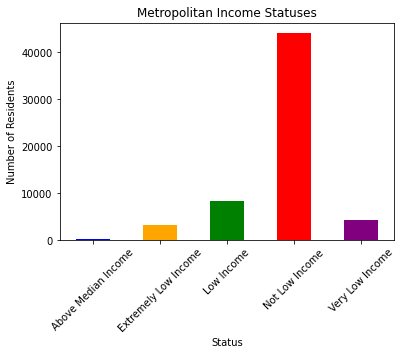

In [ ]:
#Metro Income Level counts:
#Extremely Low Income     3201
#Low Income               8273
#Above Median Income       267
#Not Low Income          44128
#Very Low Income          4192

metro_p = metro_households.groupby(['Classes']).size()
my_colors = 'rgbky'
metro_p.plot(kind = 'bar', color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Metropolitan Income Statuses')
plt.xlabel('Status')
plt.ylabel('Number of Residents')
plt.xticks(rotation = 45)
plt.ylabel('Number of Residents');

In [ ]:
metro_households.groupby(['Classes']).size()

Classes
Above Median Income       267
Extremely Low Income     3201
Low Income               8273
Not Low Income          44128
Very Low Income          4192
dtype: int64

# **Rural Analysis**# 

In [ ]:
rural_household = individual_data[individual_data['METRO'] == 1]

In [ ]:
(rural_household['Classes'].value_counts() / rural_household.shape[0]) * 100

Not Low Income          57.030056
Low Income              19.689251
Very Low Income         12.913907
Extremely Low Income     9.730005
Above Median Income      0.636780
Name: Classes, dtype: float64

In [ ]:
(rural_household['Tenure'].value_counts() / rural_household.shape[0]) * 100

Owned     76.897606
Rented    23.102394
Name: Tenure, dtype: float64

In [ ]:
# rural energy breakdown
rural_household['Sum Energy Costs'] = (rural_household['Annual Electricity Costs'] + rural_household['Annual Fuel Costs'] + rural_household['Annual Gas Costs'] + rural_household['Annual Water Costs'])
rural_household['Total Energy Cost Burden'] = (rural_household['HHINCOME'] / rural_household['Sum Energy Costs'])
rural_household['Rural Energy Burdens Bins'] = energy_burden_bins(rural_household)
(rural_household['Rural Energy Burdens Bins'].value_counts() / rural_household.shape[0])*100



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

> 20 Percent     97.962303
0-5 Percent       1.069791
10-20 Percent     0.738665
5-10 Percent      0.229241
Name: Rural Energy Burdens Bins, dtype: float64

In [ ]:
# rural rent burden levels breakdown
rural_household['Rent Burden'] = ((rural_household['RENTGRS'] * 12) /  rural_household['HHINCOME'])
rural_rent_burdens = individual_data[individual_data['METRO'] == 1]
rural_rent_burdens = rural_rent_burdens[rural_rent_burdens['Rent Burden'] != 'NaN']
rural_rent_burdens['Rent Burden Degree'] = rentburden_eval(rural_rent_burdens)
rural_rent_burdens = rural_rent_burdens[rural_rent_burdens['Rent Burden Degree'] != 'N/A']
(rural_rent_burdens['Rent Burden Degree'].value_counts()/rural_rent_burdens.shape[0]) * 100

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Not Rent Burdened          92.250639
Rent Burdened               4.296675
Extremely Rent Burdened     3.452685
Name: Rent Burden Degree, dtype: float64

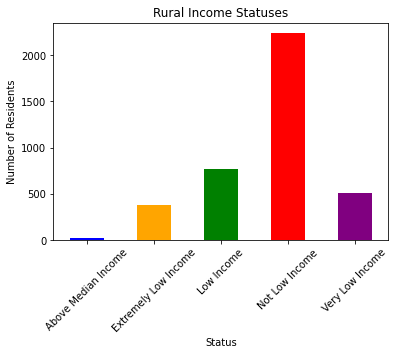

In [ ]:
#Rural Income Level counts:
#Extremely Low Income     382
#Low Income               773
#Above Median Income       25
#Not Low Income          2239
#Very Low Income          507

r = rural_household.groupby(['Classes']).size()

r.plot(kind = 'bar',color=['blue', 'orange', 'green', 'red', 'purple'])
plt.title('Rural Income Statuses')
plt.xlabel('Status')
plt.xticks(rotation = 45)
plt.ylabel('Number of Residents');

In [ ]:
rural_household.groupby(['Classes']).size()

Classes
Above Median Income       25
Extremely Low Income     382
Low Income               773
Not Low Income          2239
Very Low Income          507
dtype: int64

# **County Level Analysis**# 

County AMI data: https://www.deptofnumbers.com/income/washington/whatcom-county/

Income class breakdown: https://www.energy.gov/eere/slsc/low-income-community-energy-solutions#:~:text=Energy%20burden%20is%20defined%20as,income%20spent%20on%20energy%20costs 

In [ ]:
#["N/A", "King", "Spokane", "Pierce", "Clark", "Snohomish", "Kitsap", "Yakima", "Thurston", "Whatcom"]

def county_median_evaluator(df):
  medians = []
  for i in df['County Names']:
      if i == 'King':
          medians.append(128694)
      elif i == 'Spokane':
          medians.append(59974)
      elif i == 'Pierce':
          medians.append(79243)
      elif i == 'Clark':
          medians.append(80555)
      elif i == 'Snohomish':
          medians.append(89260)
      elif i == 'Kitsap':
          medians.append(79624)
      elif i == 'Yakima':
          medians.append(56233)
      elif i == 'Thurston':
          medians.append(78512)
      else:
          medians.append(69372)
  return medians

In [ ]:
def county_level_evaluator(df):
  levels = []
  for i in df['Income vs AMI prop']:
      if i > 0 and i < 0.3:
          levels.append('Extremely Low Income')
      elif i >= 0.3 and i < 0.5:
          levels.append('Very Low Income')
      elif i >= 0.5 and i < 0.8:
          levels.append('Low Income')
      elif i >= 0.8:
          levels.append('Not Low Income')
      else:
          levels.append('Above Median Income')
  return levels

In [ ]:
#County AMI level breakdown:
#Not Low Income          38198
#Low Income               8508
#Very Low Income          4738
#Extremely Low Income     4183
#Above Median Income       247

counties = household_data[household_data['County Names'] != 'N/A']
counties['County AMI'] = county_median_evaluator(counties)
counties['Income vs AMI prop'] = (counties['HHINCOME'] / counties['County AMI'])
counties['County Household Levels'] = county_level_evaluator(counties)
counties.drop(columns = ['Classes','County AMI', 'Income vs AMI prop'], inplace = True)
counties.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,METRO,SERIAL,RENTGRS,FAMSIZE,County Names,Climate Zones,Tenure,Annual Electricity Costs,Annual Gas Costs,Annual Water Costs,Annual Fuel Costs,HHINCOME,HHWT,NFAMS,Meets Income Threshold,Total Energy Costs,[WEIGHTED] Energy Spend,[WEIGHTED] Household Occupancy,[WEIGHTED] Gas Spend,Poverty,County Household Levels
20379,2,1359290,0,1,King,Northwest,Owned,360,240,9997,9993,135000,102.0,1,True,20590,2100180.0,102.0,24480.0,False,Not Low Income
20380,2,1359292,0,3,King,Northwest,Owned,1800,480,690,9993,94940,446.0,1,True,12963,5781498.0,1338.0,214080.0,False,Low Income
20381,2,1359292,0,3,King,Northwest,Owned,1800,480,690,9993,94940,446.0,1,True,12963,5781498.0,1338.0,214080.0,False,Low Income
20382,2,1359292,0,3,King,Northwest,Owned,1800,480,690,9993,94940,446.0,1,True,12963,5781498.0,1338.0,214080.0,False,Low Income
20383,2,1359294,0,2,King,Northwest,Owned,2400,9992,1200,9993,93500,117.0,1,True,23585,2759445.0,234.0,1169064.0,False,Low Income


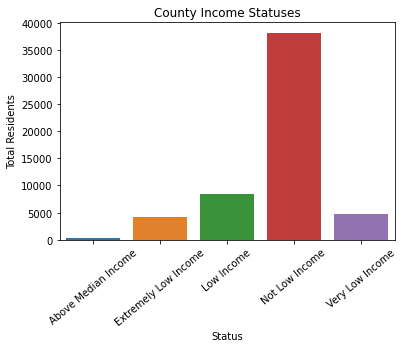

In [ ]:
county_median_breakdown = counties.groupby('County Household Levels', as_index = False).size()
sns.barplot(x = 'County Household Levels', y = 'size', data = county_median_breakdown)
plt.title('County Income Statuses')
plt.xlabel('Status')
plt.ylabel('Total Residents');
plt.xticks(rotation = 40);

In [ ]:
county_median_breakdown = counties.groupby('County Household Levels', as_index = False).size()
county_median_breakdown

,County Household Levels,size
0,Above Median Income,247
1,Extremely Low Income,4183
2,Low Income,8508
3,Not Low Income,38198
4,Very Low Income,4738


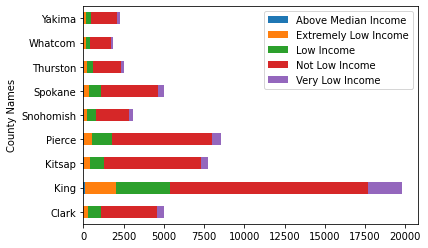

In [ ]:
countybasis = counties.groupby(['County Names','County Household Levels']).size().unstack()
countybasis = countybasis.plot(kind='barh',stacked=True,legend=True)
countybasis.legend();

# **Family Size - Multi/Single**# 

In [ ]:
def famtype(df):
  types = []
  for num in df['NFAMS']:
    if num == 1:
      types.append('Single Family')
    else:
      types.append('Multi-Family')
  return types 

In [ ]:
household_data['Building Type'] = famtype(household_data)
household_data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,METRO,SERIAL,RENTGRS,FAMSIZE,County Names,Climate Zones,Tenure,Annual Electricity Costs,Annual Gas Costs,Annual Water Costs,Annual Fuel Costs,HHINCOME,HHWT,NFAMS,Meets Income Threshold,Total Energy Costs,[WEIGHTED] Energy Spend,[WEIGHTED] Household Occupancy,[WEIGHTED] Gas Spend,Poverty,Classes,Building Type
877,0,1359289,0,2,N/A,N/A,Owned,960,9993,900,9993,56600,71.0,1,False,21846,1551066.0,142.0,709503.0,False,Not Low Income,Single Family
878,0,1359289,0,2,N/A,N/A,Owned,960,9993,900,9993,56600,71.0,1,False,21846,1551066.0,142.0,709503.0,False,Not Low Income,Single Family
879,0,1359291,0,1,N/A,N/A,Owned,1080,9993,300,200,70000,66.0,1,True,11573,763818.0,66.0,659538.0,False,Not Low Income,Single Family
880,2,1359298,0,2,N/A,N/A,Owned,480,9993,1100,9993,197000,66.0,1,True,21566,1423356.0,132.0,659538.0,False,Not Low Income,Single Family
881,2,1359298,0,2,N/A,N/A,Owned,480,9993,1100,9993,197000,66.0,1,True,21566,1423356.0,132.0,659538.0,False,Not Low Income,Single Family


In [ ]:
household_data['Building Type'].value_counts()

Single Family    67894
Multi-Family      6568
Name: Building Type, dtype: int64

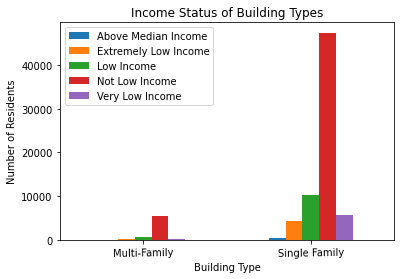

In [ ]:
buildingstypes = household_data.groupby(['Building Type','Classes']).size().unstack()
buildingstypes = buildingstypes.plot(kind='bar',stacked=False,legend=True)
plt.title('Income Status of Building Types')
plt.ylabel('Number of Residents')
plt.xticks(rotation = 1)
buildingstypes.legend();

In [ ]:
household_data.groupby(['Building Type','Classes']).size()

Building Type  Classes             
Multi-Family   Above Median Income         9
               Extremely Low Income      246
               Low Income                699
               Not Low Income           5367
               Very Low Income           247
Single Family  Above Median Income       346
               Extremely Low Income     4303
               Low Income              10258
               Not Low Income          47375
               Very Low Income          5612
dtype: int64

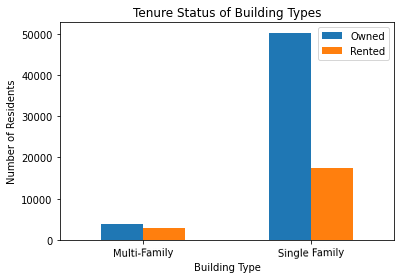

In [ ]:
buildingstypes = household_data.groupby(['Building Type','Tenure']).size().unstack()
buildingstypes = buildingstypes.plot(kind='bar',stacked=False,legend=True)
plt.title('Tenure Status of Building Types')
plt.ylabel('Number of Residents')
plt.xticks(rotation = 1)
buildingstypes.legend();

In [ ]:
household_data.groupby(['Building Type','Tenure']).size()

Building Type  Tenure
Multi-Family   Owned      3834
               Rented     2734
Single Family  Owned     50397
               Rented    17497
dtype: int64

# **Lower Income Analysis**#

In [ ]:
low_incomes = individual_data[(individual_data['Classes'] != 'Above Median Income') & (individual_data['Classes'] != 'Not Low Income')]
low_incomes.head()

,YEAR,FAMSIZE,METRO,SERIAL,HHWT,HHTYPE,County ICPs,AGE,County Names,Climate Zones,STRATA,GQ,Tenure,OWNERSHPD,RENTGRS,Annual Electricity Costs,Annual Gas Costs,Annual Water Costs,Annual Fuel Costs,HHINCOME,PERNUM,PERWT,NFAMS,Sum Energy Costs,Energy Cost Burden,Heating Fuel Cost,Rent Burden,Heating Fuel Cost Burden,Fuel as % of Total Energy,Meets Income Threshold,Classes,Energy Burdens Bins,Electricity Costs,Gas Costs,Additional Heating Fuel Costs
884,2019,4,0,1359305,25.0,1,0,27,N/A,N/A,1020053,1,Rented,22,1400,9997,9997,9997,9993,67000,1,25.0,1,39984,1.675670,19990,0.250746,3.351676,2.0002,False,Low Income,> 20 Percent,Electricity Costs included in rent or in condo...,Gas Costs included in rent or in condo fee,No charge or no Fuel Costs used
885,2019,4,0,1359305,25.0,1,0,31,N/A,N/A,1020053,1,Rented,22,1400,9997,9997,9997,9993,67000,2,26.0,1,39984,1.675670,19990,0.250746,3.351676,2.0002,False,Low Income,> 20 Percent,Electricity Costs included in rent or in condo...,Gas Costs included in rent or in condo fee,No charge or no Fuel Costs used
886,2019,4,0,1359305,25.0,1,0,1,N/A,N/A,1020053,1,Rented,22,1400,9997,9997,9997,9993,67000,3,21.0,1,39984,1.675670,19990,0.250746,3.351676,2.0002,False,Low Income,> 20 Percent,Electricity Costs included in rent or in condo...,Gas Costs included in rent or in condo fee,No charge or no Fuel Costs used
887,2019,4,0,1359305,25.0,1,0,10,N/A,N/A,1020053,1,Rented,22,1400,9997,9997,9997,9993,67000,4,18.0,1,39984,1.675670,19990,0.250746,3.351676,2.0002,False,Low Income,> 20 Percent,Electricity Costs included in rent or in condo...,Gas Costs included in rent or in condo fee,No charge or no Fuel Costs used
888,2019,1,1,1359306,49.0,6,0,62,N/A,N/A,1080053,1,Rented,22,220,9997,9997,9997,9997,8800,1,50.0,1,39988,0.220066,19994,0.300000,0.440132,2.0000,False,Extremely Low Income,> 20 Percent,Electricity Costs included in rent or in condo...,Gas Costs included in rent or in condo fee,Fuel Costs included in rent or in condo fee


In [ ]:
(low_incomes['Electricity Costs'].value_counts() / low_incomes.shape[0])*100

Electricity Costs paid separately                     93.990171
Electricity Costs included in rent or in condo fee     4.249941
No charge or no Electricity Costs used                 1.759888
Name: Electricity Costs, dtype: float64

In [ ]:
(low_incomes['Gas Costs'].value_counts() / low_incomes.shape[0])*100

No charge or no Gas Costs used                62.939387
Gas Costs paid separately                     26.931898
Included in electricity payment                7.868008
Gas Costs included in rent or in condo fee     2.260707
Name: Gas Costs, dtype: float64

In [ ]:
(low_incomes['Additional Heating Fuel Costs'].value_counts() / low_incomes.shape[0])*100

No charge or no Fuel Costs used                89.230049
Fuel Costs paid separately                     10.053826
Fuel Costs included in rent or in condo fee     0.716125
Name: Additional Heating Fuel Costs, dtype: float64

In [ ]:
rural_low_incomes = low_incomes[low_incomes['METRO']==1]
rural_low_incomes.head();

In [ ]:
(rural_low_incomes['Electricity Costs'].value_counts() / rural_low_incomes.shape[0])*100

Electricity Costs paid separately                     94.223827
Electricity Costs included in rent or in condo fee     3.971119
No charge or no Electricity Costs used                 1.805054
Name: Electricity Costs, dtype: float64

In [ ]:
(rural_low_incomes['Gas Costs'].value_counts() / rural_low_incomes.shape[0])*100

No charge or no Gas Costs used                85.078219
Gas Costs paid separately                     11.131167
Included in electricity payment                1.985560
Gas Costs included in rent or in condo fee     1.805054
Name: Gas Costs, dtype: float64

In [ ]:
(rural_low_incomes['Additional Heating Fuel Costs'].value_counts() / rural_low_incomes.shape[0])*100

No charge or no Fuel Costs used                85.499398
Fuel Costs paid separately                     14.019254
Fuel Costs included in rent or in condo fee     0.481348
Name: Additional Heating Fuel Costs, dtype: float64

In [ ]:
metro_low_incomes = low_incomes[low_incomes['METRO'] == 2]
metro_low_incomes.head();

In [ ]:
(metro_low_incomes['Electricity Costs'].value_counts() / metro_low_incomes.shape[0])*100

Electricity Costs paid separately                     93.974212
Electricity Costs included in rent or in condo fee     4.385293
No charge or no Electricity Costs used                 1.640495
Name: Electricity Costs, dtype: float64

In [ ]:
(metro_low_incomes['Gas Costs'].value_counts() / metro_low_incomes.shape[0])*100

No charge or no Gas Costs used                59.351462
Gas Costs paid separately                     28.928891
Included in electricity payment                9.338695
Gas Costs included in rent or in condo fee     2.380952
Name: Gas Costs, dtype: float64

In [ ]:
(metro_low_incomes['Additional Heating Fuel Costs'].value_counts() / metro_low_incomes.shape[0])*100

No charge or no Fuel Costs used                91.503894
Fuel Costs paid separately                      7.736499
Fuel Costs included in rent or in condo fee     0.759607
Name: Additional Heating Fuel Costs, dtype: float64